# STRd iSPN neuron model

In [1]:
import numpy as np
import nest
nest.set_verbosity('M_WARNING')
nest.ResetKernel()
nest.Install('bgmodule')

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [3]:
#model = 'aeif_cond_exp'
model = 'aeif_cond_bg'
V_rest = -84.6
V_th = -49.
params = {'C_m': 102.3 *1,
          'g_L': 8.7 *4.2,
          'E_L': V_rest,
          'I_e': -100.,
          'a': -15.,
          'b': 350., #450.,
          'tau_w': 17.,
          'V_th': V_th,
          'Delta_T': 16.,
          'V_reset': -49.,
          'V_peak': 33.5,
          't_ref': 3.65,
         }

In [4]:
#amps = np.linspace(-250., 550., 31)
amps = np.concatenate((np.linspace(-250., 330., 30), np.linspace(350., 550., 11)), axis=0)
stimuli = [{'delay': 100., 'duration': 1000., 'amp': amp} for amp in amps]

In [5]:
def simulate(time, stim, params, V_init=None):
    nest.ResetKernel()
    nrn = nest.Create(model, params=params)
    mme = nest.Create('multimeter', params={'record_from': ['V_m', 'w']})
    spd = nest.Create('spike_recorder')
    nest.Connect(mme, nrn)
    nest.Connect(nrn, spd)

    if V_init:
        nest.SetStatus(nrn, {'V_m': V_init})
    else:
        nest.SetStatus(nrn, {'V_m': V_rest})
    nest.Simulate(stim['delay'])
    I_e = nest.GetStatus(nrn, 'I_e')[0]
    nest.SetStatus(nrn, {'I_e': I_e + stim['amp']})
    print('I_e=', I_e + stim['amp'])
    nest.Simulate(stim['duration'])
    nest.SetStatus(nrn, {'I_e': I_e})
    nest.Simulate(time - stim['delay'] - stim['duration'])
    
    spikes = nest.GetStatus(spd, keys='events')[0]['times']
    times = nest.GetStatus(mme)[0]['events']['times']
    V_m = nest.GetStatus(mme)[0]['events']['V_m']
    w = nest.GetStatus(mme)[0]['events']['w']
    sweep_data = {'stim_amp': stim['amp'], 
                  'times': times, 
                  'V_m': V_m, 
                  'w': w, 
                  'spikes': spikes}
    return sweep_data

In [6]:
sweeps = [simulate(1000. + 2*stim['delay'], stim, params) for stim in stimuli]

I_e= -350.0
I_e= -330.0
I_e= -310.0
I_e= -290.0
I_e= -270.0
I_e= -250.0
I_e= -230.0
I_e= -210.0
I_e= -190.0
I_e= -170.0
I_e= -150.0
I_e= -130.0
I_e= -110.0
I_e= -90.0
I_e= -70.0
I_e= -50.0
I_e= -30.0
I_e= -10.0
I_e= 10.0
I_e= 30.0
I_e= 50.0
I_e= 70.0
I_e= 90.0
I_e= 110.0
I_e= 130.0
I_e= 150.0
I_e= 170.0
I_e= 190.0
I_e= 210.0
I_e= 230.0
I_e= 250.0
I_e= 270.0
I_e= 290.0
I_e= 310.0
I_e= 330.0
I_e= 350.0
I_e= 370.0
I_e= 390.0
I_e= 410.0
I_e= 430.0
I_e= 450.0


In [7]:
def with_peaks(volts, times, spikes, vpeak=0.0):
    spike_times = list(spikes)
    time_with_spikes = []
    volt_with_peaks = []
    next_spike = spike_times.pop(0) if spike_times else times[-1]
    for volt, time in zip(volts, times):
        if time > next_spike:
            time_with_spikes.append(next_spike)
            volt_with_peaks.append(vpeak)
            next_spike = spike_times.pop(0) if spike_times else times[-1]
        time_with_spikes.append(time)
        volt_with_peaks.append(volt)
    return np.array(time_with_spikes), np.array(volt_with_peaks)

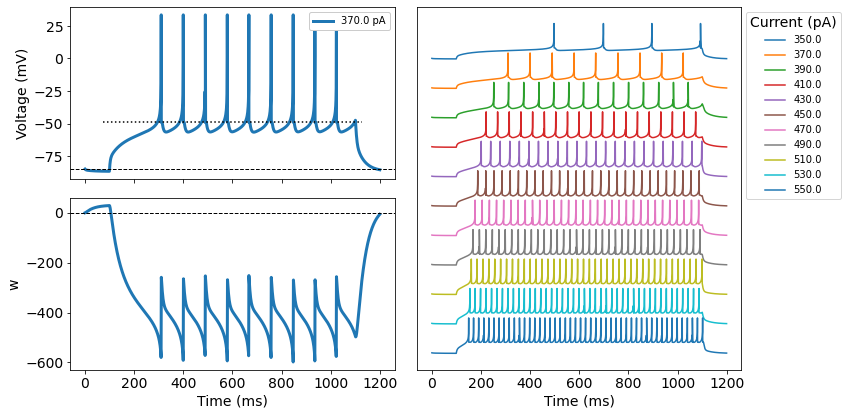

In [8]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(122)
vwplot = 1
for i, sweep in enumerate([x for x in sweeps if len(x['spikes']) > 2]):
    ts = sweep['times']
    vs = sweep['V_m']
    ws = sweep['w']
    tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
    ax3.plot(tp, vp - i*100, label=round(sweep['stim_amp'], 1))
    if i == vwplot:
        ax1.plot(tp, vp, 'tab:blue', lw=3, label=f"{round(sweep['stim_amp'], 1)} pA")
        ax2.plot(ts, ws, 'tab:blue', lw=3)
ax1.axhline(V_rest, c='k', ls='--', lw=1)
ax1.axhline(V_th, xmin=0.1, xmax=0.9, c='k', ls=':')
ax2.axhline(0, c='k', ls='--', lw=1)
ax2.set_xlabel('Time (ms)')
ax3.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax2.set_ylabel('w')
ax3.set_yticks([])
ax1.legend(loc='upper right', fontsize=10, framealpha=1)
ax3.legend(title='Current (pA)', bbox_to_anchor=(1, 1), fontsize=10)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()

In [9]:
currents_iv = [sweep['stim_amp'] for sweep in sweeps if len(sweep['spikes']) == 0]
volts_iv = [sweep['V_m'][1090] for sweep in sweeps if len(sweep['spikes']) == 0]
currents = [sweep['stim_amp'] for sweep in sweeps if len(sweep['spikes']) > 1]
rates_ini = np.array([1e3 / (sweep['spikes'][1] - sweep['spikes'][0]) 
             for sweep in sweeps if len(sweep['spikes']) > 1])
rates_avg = np.array([np.array(1e3 / (sweep['spikes'][1:] - sweep['spikes'][:-1])).mean()
             for sweep in sweeps if len(sweep['spikes']) > 1])
adapt = rates_avg / rates_ini

In [10]:
import json
spec = json.load(open('expdata/151123_c1_D2-spec.json'))

In [11]:
exp_stimuli_iv = [stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IV']]
exp_volts_iv = [feat['steady_state_voltage_stimend'][0] for stim, feat in spec['cell_features']['IV']]
exp_stimuli = [stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IDthresh']]
exp_rates_ini = np.array([feat['inv_first_ISI'][0] for stim, feat in spec['cell_features']['IDthresh']])
exp_rates_avg = np.array([feat['mean_frequency'][0] for stim, feat in spec['cell_features']['IDthresh']])
exp_adapt = exp_rates_avg / exp_rates_ini

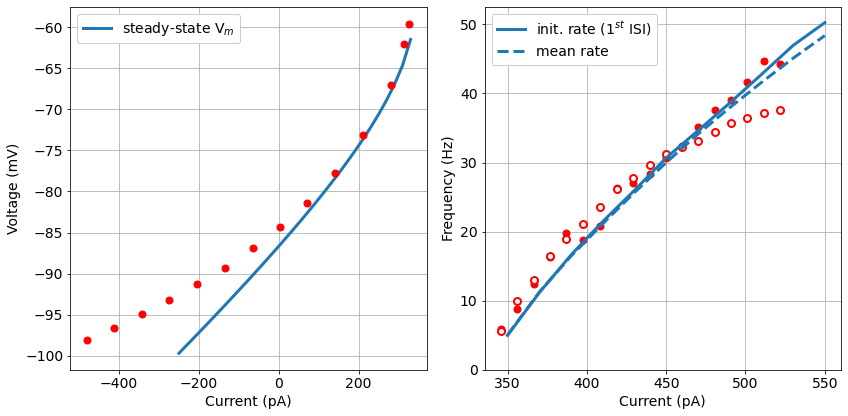

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(currents_iv, volts_iv, lw=3, label='steady-state V$_m$')
ax1.plot(exp_stimuli_iv, exp_volts_iv, 'ro', markersize=7)
ax1.plot([stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IDthresh-sub']],
         [feat['steady_state_voltage_stimend'][0] for stim, feat in spec['cell_features']['IDthresh-sub']],
         'ro', markersize=7)

ax1.legend(framealpha=1)
ax1.grid()
ax1.set_xlabel('Current (pA)')
ax1.set_ylabel('Voltage (mV)')

ax2.plot(exp_stimuli, exp_rates_ini, 'ro', markersize=7)
ax2.plot(exp_stimuli, exp_rates_avg, 'ro', markersize=7, markerfacecolor='w', markeredgewidth=2)

#ax2.plot([stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IV-supra']], 
#        np.array([feat['inv_first_ISI'][0] for stim, feat in spec['cell_features']['IV-supra']]),
#        'ro', markersize=7)
#ax2.plot([stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IV-supra']], 
#        np.array([feat['mean_frequency'][0] for stim, feat in spec['cell_features']['IV-supra']]), 
#        'ro', markersize=7, markerfacecolor='w', markeredgewidth=2)

ax2.plot(currents, rates_ini, linewidth=3, c='tab:blue', label='init. rate (1$^{st}$ ISI)')
ax2.plot(currents, rates_avg, linewidth=3, c='tab:blue', ls='--', label='mean rate')

ax2.legend(framealpha=1)
ax2.set_ylim(0)
ax2.grid()
ax2.set_xlabel('Current (pA)')
ax2.set_ylabel('Frequency (Hz)')
fig.tight_layout()

In [13]:
import pandas
pandas.DataFrame(zip(exp_stimuli, exp_rates_ini, exp_rates_avg, exp_adapt),
                 columns=['stim', 'f_1', 'f_mean', 'adapt'])

,stim,f_1,f_mean,adapt
0,345.715911,5.924171,5.594832,0.944408
1,356.191122,8.787346,9.897895,1.126380
2,366.529701,12.468828,13.067953,1.048050
3,376.945566,16.393443,16.450751,1.003496
4,387.153545,19.841270,18.892009,0.952157
5,397.664696,18.761726,21.083279,1.123739
6,408.410827,20.746888,23.589641,1.137021
7,418.930634,26.315789,26.121465,0.992616
8,429.042952,27.100271,27.748348,1.023914
9,439.569510,28.409091,29.678068,1.044668


In [14]:
pandas.DataFrame(zip(currents, rates_ini, rates_avg, adapt), columns=['stim', 'f_1', 'f_mean', 'adapt'])

,stim,f_1,f_mean,adapt
0,350.0,4.982561,5.038105,1.011148
1,370.0,11.160714,11.234331,1.006596
2,390.0,16.611296,16.449458,0.990257
3,410.0,21.459227,21.135852,0.984931
4,430.0,25.974026,25.657269,0.987805
5,450.0,30.674847,29.993440,0.977786
6,470.0,34.602076,34.112758,0.985859
7,490.0,38.610039,37.926425,0.982294
8,510.0,42.735043,41.585215,0.973094
9,530.0,46.948357,45.097648,0.960580


In [15]:
amps = np.linspace(-274., 349., 10)
stimuli2 = [{'delay': 100., 'duration': 1000., 'amp': amp} for amp in amps]

In [16]:
params2 = params.copy()
sweeps2 = [simulate(1400., stim, params2) for stim in stimuli2]

I_e= -374.0
I_e= -304.77777777777777
I_e= -235.55555555555554
I_e= -166.33333333333331
I_e= -97.11111111111109
I_e= -27.888888888888857
I_e= 41.33333333333337
I_e= 110.5555555555556
I_e= 179.77777777777783
I_e= 249.0


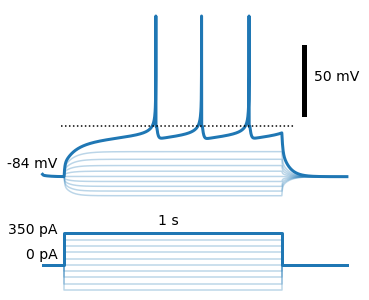

In [17]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

tc = [0., 100., 100., 1100., 1100, 1400.]
for sweep in sweeps2[:-1]:
    ts = sweep['times']
    vs = sweep['V_m']
    tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
    ax1.plot(tp, vp, 'tab:blue', alpha=0.3)
    dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
    ax2.plot(tc, dc, 'tab:blue', alpha=0.3)
sweep = sweeps2[-1]
ts = sweep['times']
vs = sweep['V_m']
tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
ax1.plot(tp, vp, 'tab:blue', lw=3)
dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
ax2.plot(tc, dc, 'tab:blue', lw=3)

ax1.plot([1200, 1200], [10, -40], 'k', linewidth=5)
ax1.axhline(V_th, xmin=0.1, xmax=0.8, c='k', ls=':')
ax1.annotate('50 mV', xy=(1250, -15), xycoords='data')
ax1.annotate('-84 mV', xy=(70, -80), xycoords='data', ha='right')
ax2.annotate('350 pA', xy=(70, 350), xycoords='data', ha='right')
ax2.annotate('0 pA', xy=(70, 70), xycoords='data', ha='right')
ax2.annotate('1 s', xy=(0.42, 1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');

In [18]:
amps = np.linspace(-277., 346., 10)
stimuli2 = [{'delay': 100., 'duration': 1000., 'amp': amp} for amp in amps]

In [19]:
params2 = params.copy()
params2['I_e'] = params['I_e'] + 3.
sweeps2 = [simulate(1400., stim, params2, V_init=-87.6) for stim in stimuli2]

I_e= -374.0
I_e= -304.77777777777777
I_e= -235.55555555555554
I_e= -166.33333333333331
I_e= -97.11111111111109
I_e= -27.888888888888857
I_e= 41.33333333333337
I_e= 110.5555555555556
I_e= 179.77777777777783
I_e= 249.0


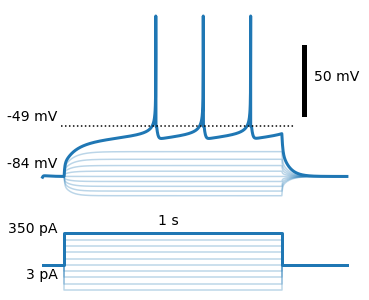

In [20]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

tc = [0., 100., 100., 1100., 1100, 1400.]
for sweep in sweeps2[:-1]:
    ts = sweep['times']
    vs = sweep['V_m']
    tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
    ax1.plot(tp, vp, 'tab:blue', alpha=0.3)
    dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
    ax2.plot(tc, dc, 'tab:blue', alpha=0.3)
sweep = sweeps2[-1]
ts = sweep['times']
vs = sweep['V_m']
tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
ax1.plot(tp, vp, 'tab:blue', lw=3)
dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
ax2.plot(tc, dc, 'tab:blue', lw=3)

ax1.plot([1200, 1200], [10, -40], 'k', linewidth=5)
ax1.axhline(V_th, xmin=0.1, xmax=0.8, c='k', ls=':')
ax1.annotate('50 mV', xy=(1250, -15), xycoords='data')
ax1.annotate('-84 mV', xy=(70, -80), xycoords='data', ha='right')
ax1.annotate('-49 mV', xy=(70, -45), xycoords='data', ha='right')
ax2.annotate('350 pA', xy=(70, 350), xycoords='data', ha='right')
ax2.annotate('3 pA', xy=(70, -150), xycoords='data', ha='right')
ax2.annotate('1 s', xy=(0.42, 1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');

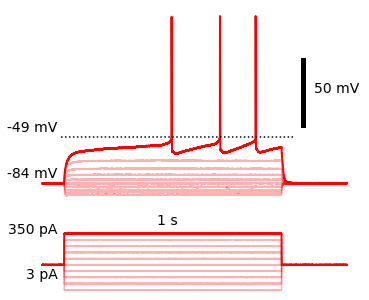

In [21]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

for i in range(500, 509, 1):
    te, ve = np.loadtxt(f'expdata/151123_c1_D2/ECall_IV_ch1_{i}.dat').T
    ax1.plot(te, ve - 11.5, 'red', alpha=0.3)
    te, ce = np.loadtxt(f'expdata/151123_c1_D2/ECall_IV_ch0_{i}.dat').T
    ax2.plot(te, ce, 'red', alpha=0.3)
i = 509
te, ve = np.loadtxt(f'expdata/151123_c1_D2/ECall_IV_ch1_{i}.dat').T
ax1.plot(te, ve - 11.5, 'red', lw=2)
ax1.axhline(V_th, xmin=0.1, xmax=0.8, c='k', ls=':')
te, ce = np.loadtxt(f'expdata/151123_c1_D2/ECall_IV_ch0_{i}.dat').T
ax2.plot(te, ce, 'red', lw=2)
ax1.plot([1200, 1200], [10, -40], 'k', linewidth=5)
ax1.annotate('50 mV', xy=(1250, -15), xycoords='data')
ax1.annotate('-84 mV', xy=(70, -80), xycoords='data', ha='right')
ax1.annotate('-49 mV', xy=(70, -45), xycoords='data', ha='right')
ax2.annotate('350 pA', xy=(70, 350), xycoords='data', ha='right')
ax2.annotate('3 pA', xy=(70, -150), xycoords='data', ha='right')
ax2.annotate('1 s', xy=(0.42,1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');

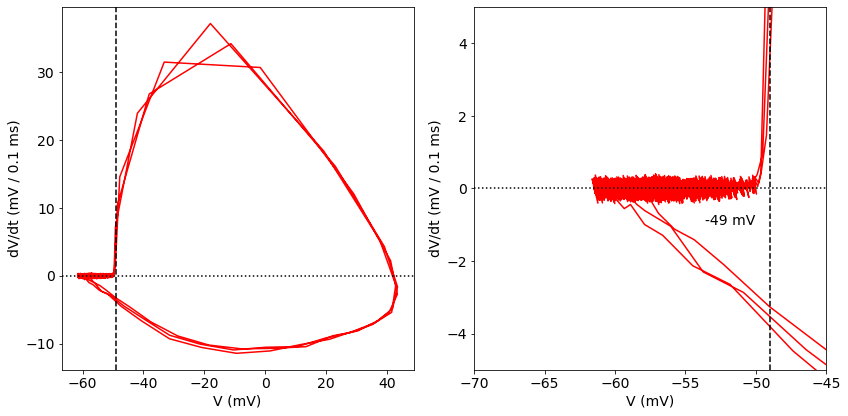

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
vthresh = -49.
vv = ve - 11.5
dv = np.array([y-x for x, y in zip(ve[:-1], ve[1:])])
ax1.plot(vv[2000:-4000-1], dv[2000:-4000], 'r')
ax1.axvline(vthresh, c='k', ls='--')
ax1.axhline(0, c='k', ls=':')
ax2.plot(vv[2000:-4000-1], dv[2000:-4000], 'r')
ax2.axvline(vthresh, c='k', ls='--')
ax2.set_xlim(-70, -45), ax2.set_ylim(-5., 5)
ax2.axhline(0, c='k', ls=':')
ax2.annotate('-49 mV', xy=(-50, -1), xycoords='data', ha='right')
ax1.set_xlabel('V (mV)'), ax1.set_ylabel('dV/dt (mV / 0.1 ms)')
ax2.set_xlabel('V (mV)'), ax2.set_ylabel('dV/dt (mV / 0.1 ms)')
fig.tight_layout()